Hello and welcome! This code will demonstrate a little bit of machine learning and some other features to show off data that has been gathered about competitive games inside the first-person shooter Counter-Strike. To begin: press the play button or press shift + enter at the same time.

In [1]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install ipywidgets
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

First we had to make sure that you have all the libraries you'll need to run this code successfully. Next is the fun part: Data will be parsed in and ran through a pre-compiled Machine Learning Algorithm, then a few predictions will be tested for accuracy. Please be patient this may take a moment.

Accuracy: 0.57
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.84      0.60      0.70    576000
         1.0       0.17      0.42      0.25    115200

    accuracy                           0.57    691200
   macro avg       0.51      0.51      0.47    691200
weighted avg       0.73      0.57      0.62    691200

Confusion Matrix: 
[[342941 233059]
 [ 66356  48844]]


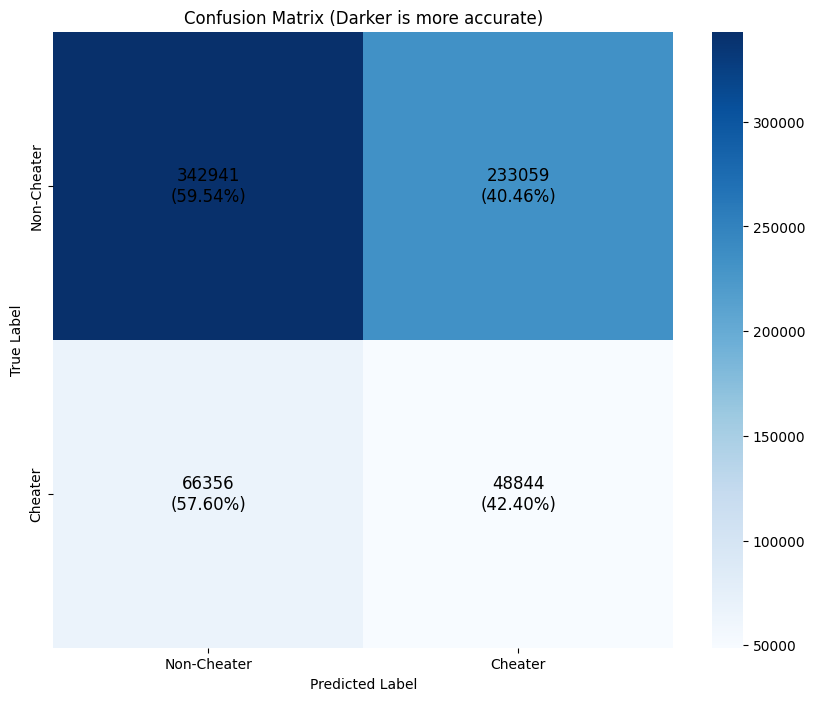

In [2]:
cheater_data = np.load('cheaters/cheaters.npy', allow_pickle=True)
legit_data = np.load('legit/legit.npy', allow_pickle=True)

cheater_subset = cheater_data[:2000]
legit_subset = legit_data[:10000]

# Combine the subsets
subset_data = np.vstack((cheater_subset, legit_subset))

# Create labels: 1 for cheaters, 0 for legit
subset_labels = np.hstack((
    np.ones(cheater_subset.shape[0]),
    np.zeros(legit_subset.shape[0])
))

# Repeat labels to match the shape of the flattened subset data
subset_labels_repeated = np.repeat(subset_labels, 30 * 192)


# Reshape the combined data to (total_subset_samples, 5)
subset_data_reshaped = subset_data.reshape(-1, 5)

# Perform stratified split to ensure equal representation in training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    subset_data_reshaped, subset_labels_repeated, test_size=0.01, random_state=42, stratify=subset_labels_repeated)
# read the pre-trained classification algorithm.
with open('classifier.pkl', 'rb') as f:
    classifier = pickle.load(f)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Classification Report: \n{classification_report}')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{conf_matrix}')

# Calculate percentages
conf_matrix_percentages = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=False, fmt='.2f', cmap='Blues', xticklabels=['Non-Cheater', 'Cheater'],
            yticklabels=['Non-Cheater', 'Cheater'])

# Annotate with raw numbers
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, f"{conf_matrix[i, j]}\n({conf_matrix_percentages[i, j]:.2f}%)",
                 ha='center', va='center', color='black', fontsize=12)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Darker is more accurate)')
plt.show()

This confusion matrix represents the accuracy of the model. The top-left and top-right indicate respectively that the machine is pretty good at predicting when behavior from a player represents a non-cheater.The top right being dark means it incorrectly diagnoses cheaters as non-cheaters more than it would like to. The overall accuracy is 57% and success is defined as above 50% accuracy. Next we have some more fun looking data, continue with the play button.

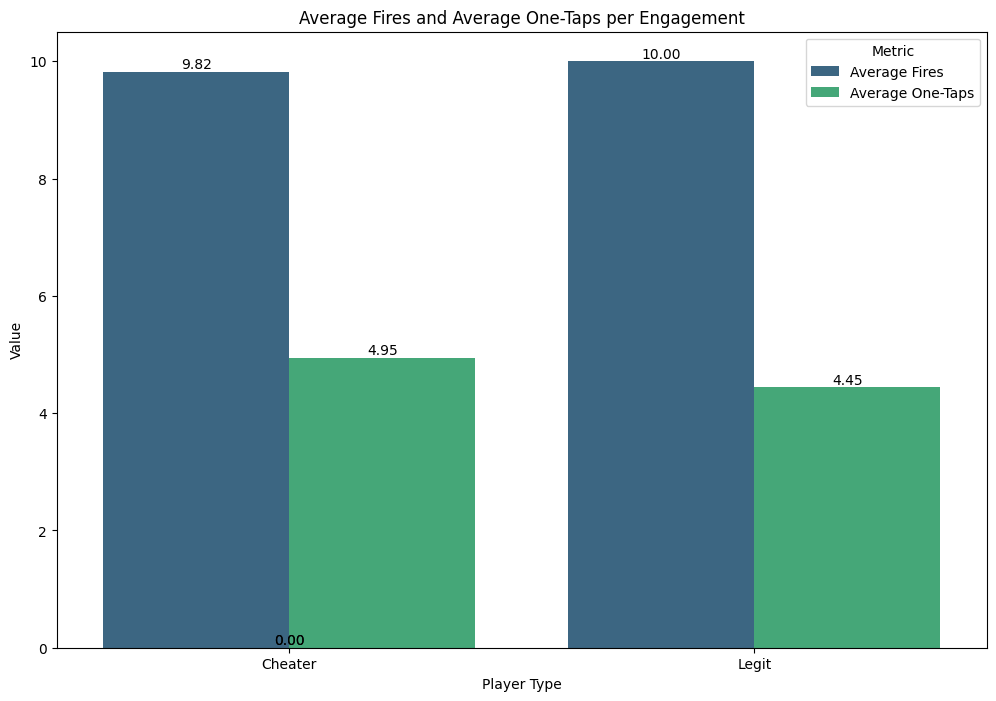

In [3]:
def average_fires_per_engagement(data):
    firing_data = data[:, :, :, 4]
    sum_firing_per_engagement = np.sum(firing_data, axis=2)
    avg_firing = np.mean(sum_firing_per_engagement)
    return avg_firing

def calculate_time_to_kill(data):
    time_to_kill_list = []
    one_tap_count = 0

    for player_data in data:
        for engagement in player_data:
            firing_sequence = engagement[:, 4]
            first_firing_index = np.argmax(firing_sequence)

            if first_firing_index < 160:
                time_to_kill_timesteps = 160 - first_firing_index
                time_to_kill_seconds = time_to_kill_timesteps / 32
                time_to_kill_list.append(time_to_kill_seconds)
            if first_firing_index == 160:
                time_to_kill_seconds = 0
                time_to_kill_list.append(time_to_kill_seconds)
                one_tap_count += 1

    if time_to_kill_list:
        average_time_to_kill_seconds = np.mean(time_to_kill_list)
    else:
        average_time_to_kill_seconds = None

    average_one_tap_count = one_tap_count / len(data)  # Average one-tap count per engagement
    return time_to_kill_list, average_time_to_kill_seconds, average_one_tap_count

avg_fires_cheater = average_fires_per_engagement(cheater_data)
avg_fires_legit = average_fires_per_engagement(legit_data)

time_to_kill_cheater, avg_time_to_kill_cheater, avg_one_tap_count_cheater = calculate_time_to_kill(cheater_data)
time_to_kill_legit, avg_time_to_kill_legit, avg_one_tap_count_legit = calculate_time_to_kill(legit_data)

ttk_data = pd.DataFrame({
    'Time to Kill (seconds)': time_to_kill_cheater + time_to_kill_legit,
    'Label': ['Cheater'] * len(time_to_kill_cheater) + ['Legit'] * len(time_to_kill_legit)
})

avg_fires_data = pd.DataFrame({
    'Type': ['Cheater', 'Legit'],
    'Average Fires': [average_fires_per_engagement(cheater_data), average_fires_per_engagement(legit_data)]
})
# Plotting

# Convert to DataFrame for easier plotting
metrics_data = pd.DataFrame({
    'Type': ['Cheater', 'Legit', 'Cheater', 'Legit'],
    'Metric': ['Average Fires', 'Average Fires', 'Average One-Taps', 'Average One-Taps'],
    'Value': [avg_fires_cheater, avg_fires_legit, avg_one_tap_count_cheater, avg_one_tap_count_legit]
})

# Grouped bar plot for average fires and average one-taps
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Type', y='Value', hue='Metric', data=metrics_data, palette='viridis')

for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Average Fires and Average One-Taps per Engagement')
plt.xlabel('Player Type')
plt.ylabel('Value')
plt.legend(title='Metric')
plt.show()

You can see that the average legitimate player fires 10 times each engagement while cheaters fire 9.82 times. You can also see that In 30 engagements cheaters have an average of 4.95 One-Taps (One-taps are rare in the game, they happen when a player strikes another targets weak point and kills them in one shot, this takes a lot of accuracy), while the average real player has a lower 4.45.

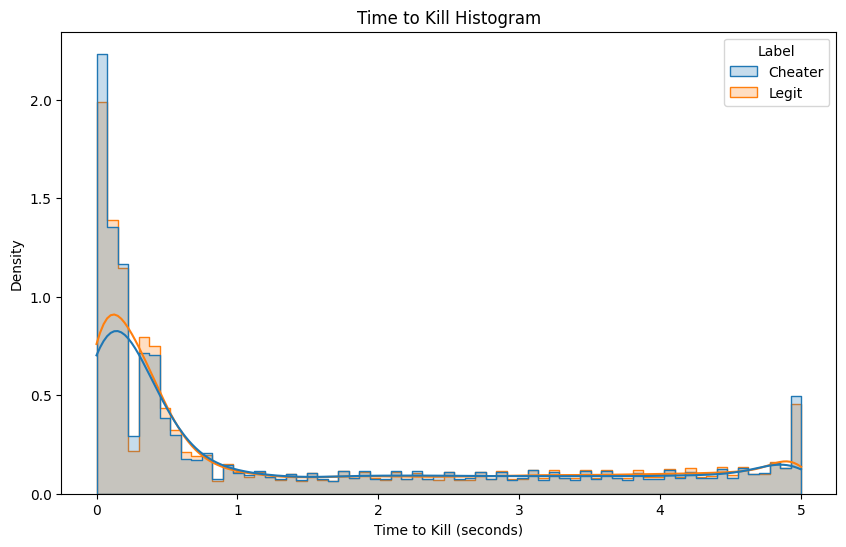

In [4]:
# Histogram for time to kill
plt.figure(figsize=(10, 6))
sns.histplot(ttk_data, x='Time to Kill (seconds)', hue='Label', kde=True, element='step', stat='density', common_norm=False)
plt.title('Time to Kill Histogram')
plt.xlabel('Time to Kill (seconds)')
plt.ylabel('Density')
plt.show()

This is some really cool looking data! It is an aggegrate of all the collected time to kill's. 

In [5]:
# Function to calculate likelihood of being a cheater
def calculate_likelihood(ttk, one_tap_count):
    # Normalize TTK likelihood
    if ttk <= avg_time_to_kill_cheater:
        ttk_likelihood = 1.0
    elif ttk >= avg_time_to_kill_legit:
        ttk_likelihood = 0.0
    else:
        ttk_likelihood = 1.0 - (ttk - avg_time_to_kill_cheater) / (avg_time_to_kill_legit - avg_time_to_kill_cheater)
    
    # Normalize one-tap likelihood
    if one_tap_count >= avg_one_tap_count_cheater:
        one_tap_likelihood = 1.0
    elif one_tap_count <= avg_one_tap_count_legit:
        one_tap_likelihood = 0.0
    else:
        one_tap_likelihood = (one_tap_count - avg_one_tap_count_legit) / (avg_one_tap_count_cheater - avg_one_tap_count_legit)
    
    # Combine both likelihoods (simple average for this example)
    combined_likelihood = (ttk_likelihood + one_tap_likelihood) / 2.0
    return combined_likelihood

# Function to update likelihood display
def update_likelihood(change):
    ttk = ttk_slider.value
    one_tap_count = one_tap_slider.value
    likelihood = calculate_likelihood(ttk, one_tap_count)
    likelihood_label.value = f"Likelihood of being a cheater: {likelihood:.2f}"

# Create a slider widget
ttk_slider = widgets.FloatSlider(
    value=(avg_time_to_kill_cheater + avg_time_to_kill_legit) / 2,
    min=avg_time_to_kill_cheater,
    max=avg_time_to_kill_legit,
    step=0.001,
    description='Time to kill:'
)

one_tap_slider = widgets.FloatSlider(
    value=(avg_one_tap_count_cheater + avg_one_tap_count_legit) / 2,
    min=avg_one_tap_count_legit,
    max=avg_one_tap_count_cheater,
    step=0.01,
    description='One Taps:'
)
# Create a label to display the likelihood
likelihood_label = widgets.Label(value="Estimated likelihood of being a cheater: ")


# Attach the update function to the slider
ttk_slider.observe(update_likelihood, names='value')
one_tap_slider.observe(update_likelihood, names ='value')
# Display the widgets
display(ttk_slider)
print("                                 Seconds")
display(one_tap_slider)
print("A one tap is when you kill the opponent in one shot. \nThe data is reflected in the average of 30 engagements")
display(likelihood_label)

# Initial update
update_likelihood({'new': ttk_slider.value})

FloatSlider(value=1.4627633854166666, description='Time to kill:', max=1.4788236458333333, min=1.446703125, st…

                                 Seconds


FloatSlider(value=4.697150000000001, description='One Taps:', max=4.9485, min=4.4458, step=0.01)

A one tap is when you kill the opponent in one shot. 
The data is reflected in the average of 30 engagements


Label(value='Estimated likelihood of being a cheater: ')

Move the sliders to demonstrate how a prediction might be made!